# Stabilizing the Cart-Pole system

In this exercise, we will use LQR to stabilize a cart-pole system and then adapt the LQR controller to get the robot to move along a specified path.

<img src="cart_pole.png" alt="drawing" width="400"/>

The difficulty of the cart-pole system is that we can only move the cart back and forth (using $u$) to move both the cart and the pendulum. Therefore, it is not trivial to find a good controller to get the pendulum to stay balanced on top of the cart while moving the cart around. We will see how we can use our optimal control approach to do such things.

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

import linear_oc_tools as oc

## The cart-pole model

The dynamics of the cart-pole can be written as
\begin{align} 
\dot{x} &= v\\
\dot{\theta} &= \omega\\
\dot{v} &= \frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \\
 \dot{\omega} &= \frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\end{align}
 
There are four states: the position $x$ and linear velocity $v$ of the cart, the angle of the pendulum $\theta$ and its angular velocity $\omega$. There is one control input $u$ which is the force applied on the cart. We will write $z = \begin{bmatrix} x & \theta & v & \omega \end{bmatrix}^T$ the state vector.

We know that the point where the pendulum is vertical is an unstable fixed point of the system. We would like to stabilize the fixed point $\bar{z} = \begin{bmatrix} \bar{x} & \bar{\theta} & \bar{v} & \bar{\omega} \end{bmatrix}^T = \begin{bmatrix} 0 & \pi & 0 & 0 \end{bmatrix}^T$.

Like most robotic systems, it is not linear. It is also underactuated, i.e. we have only one control input to control two degrees of freedom.

We will first linearize the system around $\bar{z}$ (with $\bar{u}=0$) and then compute a LQR control law to stabilize it. The control law will be approximately optimal for the nonlinear system but should be a good enough approximation when sufficiently close to the fixed point.

## Linearizing the dynamics
We linearize $\dot{z} = f(z,u) \simeq f(\bar{z},\bar{u}) + \frac{\partial f}{\partial z}_{|z=\bar{z}, u=\bar{u}} (z - \bar{z}) + \frac{\partial f}{\partial u}_{|z=\bar{z}, u=\bar{u}}(u - \bar{u})$.

We have $f(\bar{z},\bar{u}) = 0$. 

Next, we compute the partial derivatives of the dynamics with respect to all state and control variables.

For the first two equations, this is straightforward:
\begin{equation}\frac{\partial}{\partial x} v = 0,\ \frac{\partial}{\partial \theta} v = 0, \ \frac{\partial}{\partial v} v = 1,\ \frac{\partial}{\partial \omega} v = 0\end{equation}
\begin{equation}\frac{\partial}{\partial x} \omega = 0,\ \frac{\partial}{\partial \theta} \omega = 0, \ \frac{\partial}{\partial v} \omega = 0,\ \frac{\partial}{\partial \omega} \omega = 1\end{equation}

For the third equation:
$$\frac{\partial}{\partial x} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{(m_p\cos\theta(l \omega^2 + g \cos\theta) - m_pg\sin^2\theta)(m_c  + m_p \sin^2 \theta) - (u + m_p \sin\theta (l \omega^2 + g \cos\theta)) (2m_p \sin\theta\cos\theta) }{(m_c  + m_p \sin^2 \theta)^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{m_p g}{m_c}$$
Now for the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = 0$$
and for the angular velocity
$$\frac{\partial}{\partial \omega} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{2m_p \sin\theta l \omega}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0

Finally we have
$$\frac{\partial}{\partial x} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{(u\sin\theta - m_p l \omega^2 (\cos^2\theta - \sin^2 \theta) - (m_c + m_p)g\cos\theta) (l(m_c  + m_p \sin^2 \theta)) - (-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta)(2l m_p \sin\theta\cos\theta)}{(l(m_c  + m_p \sin^2 \theta))^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{(m_p + m_c) g}{lm_c}$$
For the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
and finally
$$\frac{\partial}{\partial \omega} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{- 2m_p l \omega\cos\theta \sin\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0.

We now compute the partial derivatives with respect to the control command. We have
$$\frac{\partial}{\partial u} v = 0$$
$$\frac{\partial}{\partial u} \omega = 0$$
$$\frac{\partial}{\partial u} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{1}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{m_c}$$
and the last one
$$\frac{\partial}{\partial u} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{-\cos\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{lm_c}$$

We can gather all these terms and get the linearized dynamics
$$\dot{z} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} (z - \bar{z}) + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} (u-\bar{u})$$

Finally, we change coordinates to center around the linearized point, we set $\tilde{z} = z - \bar{z}$ and $\tilde{u} = u-\bar{u}$ and get the following dynamics
$$\dot{\tilde{z}} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z} + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}$$


## Discretizing the dynamics
We now discretize the dynamics, using $\Delta t$ for the integration step. We have 
$$\tilde{z}_{n+1} = \tilde{z}_n + \Delta t \left( \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}_n \right)$$
or equivalently
$$\tilde{z}_{n+1} =  \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & \Delta t\frac{m_p g}{m_c} & 1 & 0 \\ 0 & \Delta t\frac{(m_p + m_c) g}{lm_c} & 0 & 1 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{\Delta t}{m_c} \\ \frac{\Delta t}{lm_c} \end{bmatrix} \tilde{u}_n $$

We now have an approximation of the dynamics in a form that can be used to compute linear optimal controllers (i.e. LQR). The controllers we will compute will be of the form $$ \tilde{u}_n = K_n \tilde{z}_n + k_n$$
and they will need to be transformed into
$$ u_n = K_n (z_n - \bar{z}) + k_n$$
to be used on the original system.

## Simulating the cart pole system with arbitrary controllers

Below are a few helper functions to simulate the cart-pole system and display its behavior

In [2]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u        

In [3]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<IPython.core.display.Javascript object>


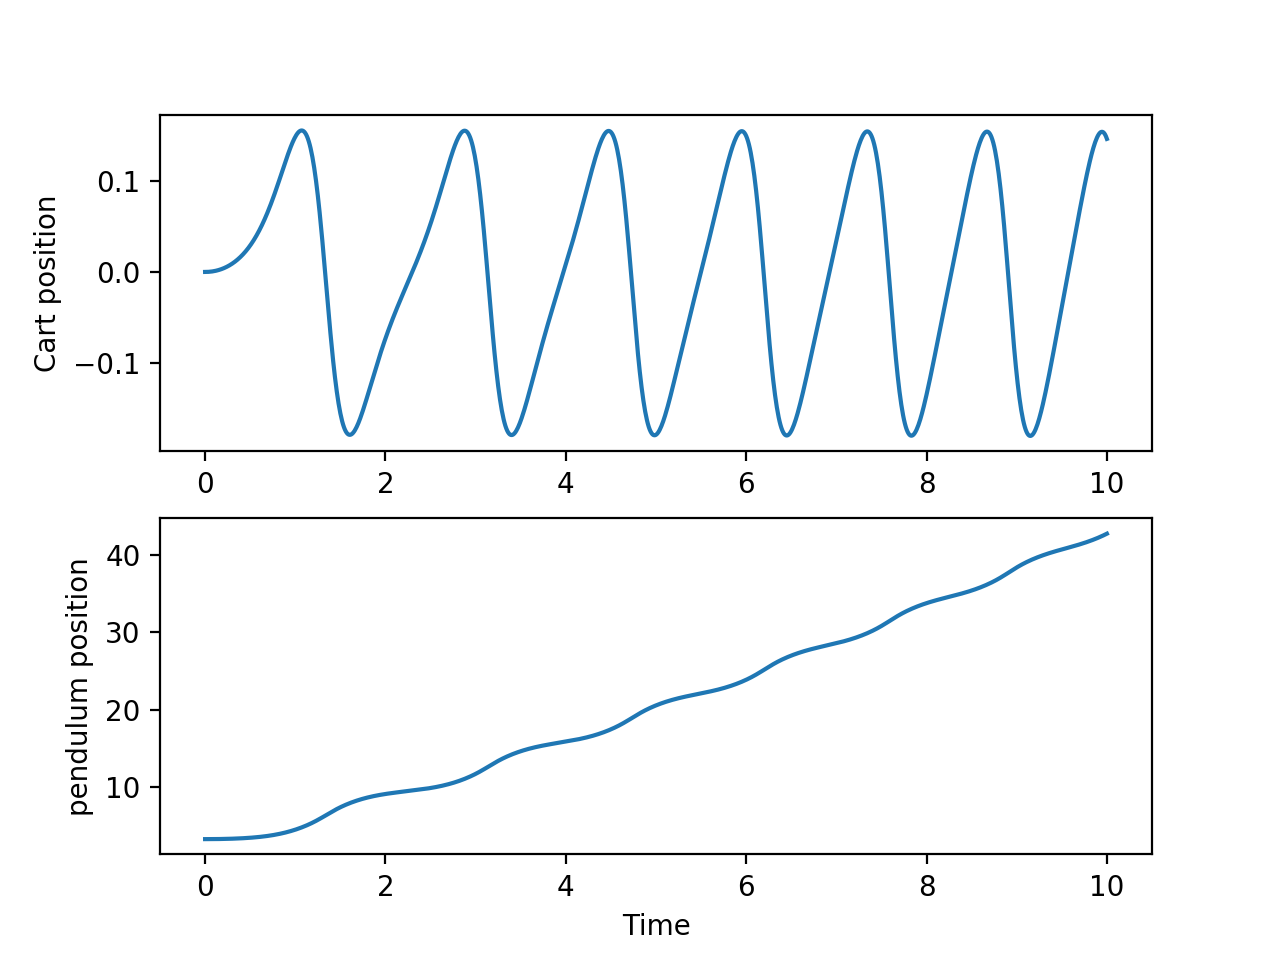

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB/6G1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA9qZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAAdaFhgCmhz+EeJXEB8N6fIJ7J
rhIV+NN9XHf+yK6HeTLxVohwsVcDo5RFQnt96ggNjzTuW/beQ9Ceg3f9LFZ5ZPoaVjdmAKgN7/Gc
Kr0gtL00uCkVv1C53J99XsNJS/gMh9fGR78jKGqiLQYpnc7fg6Gpmja2JwPurpkXHfl1gpDCA/ni
GRiQrPLlt2OPB05Qm73KqD/tHmPdnwiciUPTyOfO6Zk07JaciEI6Yzb1U3ur4ZDCUntx2SEy8nWx
NJ2p4hAZhmqmaecLjIeScUwnm9E0sSwKPUt1k7A4B5UEP2CBebM5BrR5tzxy8gmROwXuQAIz+7KF
CZMhHJyr7MX0bYv6IL2gPlMmVpE2fPJPvcQdFvc4e1VYi8npFJIgHJFoOdXwSbcwhGs2NCBHE0ps
lk38ndaNzOFTeIKdkGveGqwyaPXaD2lorbo6wo8rTrcp1pUBbE3CDgfvEsITbxzm9cEDuFBQd/DN
dYwVbMtu3QoJiQxIwwE6nfRHbLbbZDfSkEGHYLO1+D79Y4ky8OACq69ErFhxOgQ2t6HS8CzDZl4V
GR0BSljLgpUTiRuHZ4ufORG1r2DaIA4MWeUUEJP4QD5GzZDnqd3X+P05doWNkmZlqseMzqeoomQW
U+k2QEaWVFOujeHDyzRoMJIs0PYy0Qp6+l7DVhk9VHhH4ItJUyUwlJul6h4hkDBo+2IMGxtCREWL
faA33QF+veNlr2uh6tlB/zT03Od19U0i/LEd/C4H9Oyil9u4kCrJsGFqfQUa75aczjs1aZgayPVc
pn6PKQzYrU7ol/XatGg34ksvDaB/mVIHXO2yERfFKl3PyUT/7ewOQ6/QK3jhVv4/oMuJNHXSV/zO
jEMoLTfMNzdU2P6stBmPq/xMz6Nq68lQxftAkrjlU/PGGIHsSFsK7ioHPyP6NPzV+cdxmVtPj9Lc
xvkZgHaEe1i4WzlFMmcJi2VPV1iOBh8cu0AAAHkWVtUUmzU1XiIC4afM/YoTj/+zDqOCSz9aUkR1
J9ptaXXOAvbwuVTM9iqWoLO950C/YCge90zo9wjF7VOxLk8BvoQvb0RLoVcbOq4B5hvpKwWuox1Z
QI6W0daAyMx+V93eLdfiUl3Xi1N4dJXdkzPbh67zhxYLEWGrV+tJNlHFRppEfK+ZdF7jOZa1pSAY
QGizCvxyw3Kct6CQD6R4BeqEoT2Py4IS9HCPqiOUcElUNQ4fh2nUxBbGe3RdEZFSMRNJnErPWkDt
lwLhytMLy+DrfvWWX9046xlp2/6aCgqNPQPKhDsMEgXxBEi5HA0QwsbyNiJteEiqF7/VWkes4pD2
LEp7aqJ1q7a379aSaEAAnUO1z8XokALTK4oPq/W+ryY3FEjThbwGLLURItFfnfcr1PHSow7EgDpA
/QB4JJ9AgGCr8AGUZlr8uItoi6D/FW/sYi6hXDCil3y9ZzsRzpgVIGCvLZ1Vvxwr2fcZNYHnLL//
pb0FFZhcdmraDBb9oPfFz1dfuudwKN4Elq0rvtVYbtL05GFojePIBbFqfBkgxyV3QvIf+zQiiVKe
ZBZ8TIrc/vdEy+vBPjL7g/7VDulP/5z5cdvi0uYB2YEOK6B42t0FVvabRQk95mQjICnG3uzwrpKS
Ehx4eFHIavVjVdMIVqVpa850SI+DwR1tnwi544m5viQTSXA+lARxfVbGM+SNqHfBalG6GEuGSKjU
ltVTBt0z461vclqCz7LQP7YmpSvVFZxkAQPbR76cEqQNjx0IgwdF7ZorzSiyDrSOzeNWFFoo+SIQ
FoYXCKc3ZjDgCnjAG20ATHWYiYPDgAY3JKRFtiwSRcIN1/42Ix0DJTLfkC/JnBIbJyK8M6tD2TGy
T/QPL1eHpJ60Kmom+RjbAKY6ygbAfn0y2xnQADLEke7ScUBdzGUKK+kaRHbse5LHcj2ILHItCx+7
hmuUf+kXhx+hfvYP1dgN5RhsCF8CTnBOEwEklCbi51vfTqkfPQKojOewH1TjYMTBxsAAACmofeYn
/2IWbI0S+lnfxTEDr/f49P6+OYm88RRLpf5h9uqWuDERNTFUIgQEy+s1ka2baTNGRisSwh09eb11
uZf6Xi8BlOTApMYV0Nolc1L911wGHBK4+b9x3pKin+U2hwJLCJoO2bWuMCZPwfWo/k296uFiW67w
HzO7JMwHNfTy6/W0zmUcogRyUIBb/lriWNDX9/oLC+F4EwcoLmoWxl5dpjE56xCCQJZAhhfXT6JX
/wkH+swUkfOyEQwPCQm0R/QVT0HFPE0a16V2ZEZ2/NfX54LoJQLIMBlXMCWpJunqEZ0O/SKq1AZ3
x/BiE6vZRMnRJFNUc04uvwqcw5aqP14ai6qdzyblin0Iys+9yMH78IUs7UMFz8I/g4LyYWjLlt0+
ek6usbCt7BBcM6YJHDVe888PhzeY+PDu5Yro24jlRNQOUxVszbs2Q5Ox5i5nTpvLMleufEsgxKEJ
RWx3ON54vKCbhXIVdLo8lGaEppx4aPqev8CzDmtrYFLrRLCkBUcoe7R3nhrHHSqK2lLAG1vJfKms
D3T11epvmip34TO7jEI3VJMq4zx+gw4i2h4Mz7VI7CeYACDm/7r/B9DSZ5Iruhj81IAB5Kc5+wp0
DVocflHn2Fe3O7tpj68MeJQfWOdj3z0MQx89nLRWHAeEI4xCfMYsn7U5b5k+/woRJGWND1KMQK+n
jyO07tD8txtaCmcgcvVjW5+/+SUdp6sGFOZmzijgIqn4u72+x2qT4Lz8jzjYWDpYjO8MlX3n0iVU
5HE59R5T3BMqqII5vfXZwjn4iOdxIkPLMa284skwMTTQpZ3vJTBLOw0O8P14AyZQWyYWCf9LX9aN
8ff1yHTJtKXs8GqaxXEnU

In [4]:
# we show an example on how to simulate the cartpole and display its behavior

# we create a cart pole
cart = CartPole()

# we create a controller that does nothing u(z) = 0
def useless_controller(z,i):
    return 0

# we simulate the cart pole and display its behavior
z0 = np.array([0,np.pi+0.1,0.,0])
horizon_length = 1000

z,u = cart.simulate(z0, useless_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

# Question 1:
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position.

1. Write a cost function that will help stabilize the resting position $\bar{z}$ (be precise with the variables you use).
2. Compute the infinite horizon gains to stabilize the cart pole system
3. Write a function that can stabilize the system and test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system.
4. What is the behavior of the system when starting with $z_0 = [0.5, 0.3, 0., 0.]^T$? Explain the behavior.

# Question 2:
We would like to use the linearized equation to compute an optimal controller that makes the cart follow a 0.5Hz sine trajectory of amplitude 1 (i.e. $x$ displacement from -1 to 1 meter) while keeping the pendulum balanced.

1. Write a cost function that will help enforce this behavior (be precise with the variables you use).
2. Compute the finite horizon controller that creates this behavior for $N=1000$ (i.e. 10 seconds).
3. Test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system. How well can you track the desired motion?
4. What is the cost value predicted by the control design? How does it compare to the real cost value when applied to the nonlinear system? Explain.